# Supervised Learning Capstone: Predicting median household income for Neighborhoods in New York City

## Introduction
This file contains a selection of census data for different neighbors in the 5 boroughs of New York City for things like total population, racial/ethnic demographic information, employment and commuting characteristics, and more. This notebook will examine the census data in an attempt to build a model to predict median household income. 

In [122]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

nyc_df = pd.read_csv('nyc_census_tracts.csv')

In [123]:
nyc_df.head()


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


In [124]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
CensusTract        2167 non-null int64
County             2167 non-null object
Borough            2167 non-null object
TotalPop           2167 non-null int64
Men                2167 non-null int64
Women              2167 non-null int64
Hispanic           2128 non-null float64
White              2128 non-null float64
Black              2128 non-null float64
Native             2128 non-null float64
Asian              2128 non-null float64
Citizen            2167 non-null int64
Income             2101 non-null float64
IncomeErr          2101 non-null float64
IncomePerCap       2121 non-null float64
IncomePerCapErr    2121 non-null float64
Poverty            2125 non-null float64
ChildPoverty       2107 non-null float64
Professional       2124 non-null float64
Service            2124 non-null float64
Office             2124 non-null float64
Construction       2124 non-null float64
Pro

In [125]:
nyc_df.isnull().sum()

CensusTract         0
County              0
Borough             0
TotalPop            0
Men                 0
Women               0
Hispanic           39
White              39
Black              39
Native             39
Asian              39
Citizen             0
Income             66
IncomeErr          66
IncomePerCap       46
IncomePerCapErr    46
Poverty            42
ChildPoverty       60
Professional       43
Service            43
Office             43
Construction       43
Production         43
Drive              43
Carpool            43
Transit            43
Walk               43
OtherTransp        43
WorkAtHome         43
MeanCommute        61
Employed            0
PrivateWork        43
PublicWork         43
SelfEmployed       43
FamilyWork         43
Unemployment       42
dtype: int64

In [126]:
# It is evident from looking at the dataset and also seeing that a lot of the columns have the same 
#or similar number of missing values that there are entire rows with missing data. 
#As a result of this, we can drop the missing data rows.

nyc_df = nyc_df.dropna()

#We actually don't learn anything from the County column, so that can be removed.

nyc_df = nyc_df.drop(columns = 'County')

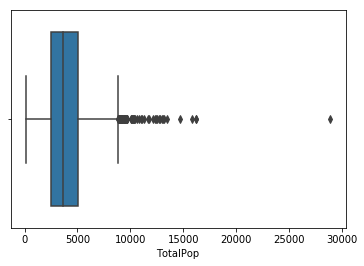

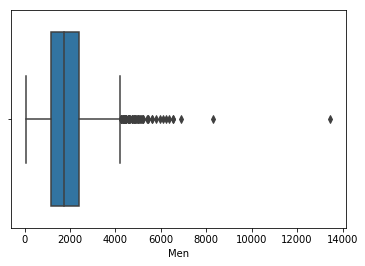

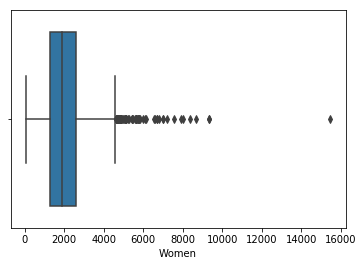

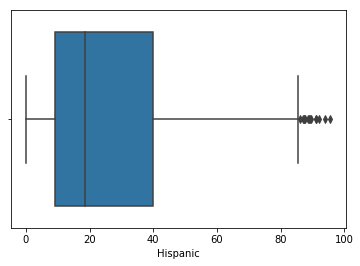

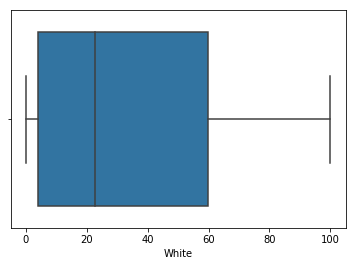

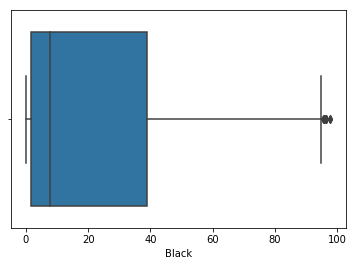

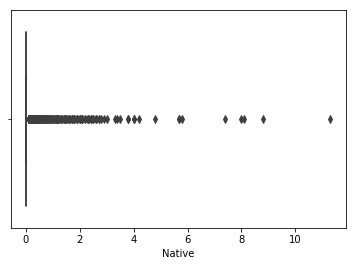

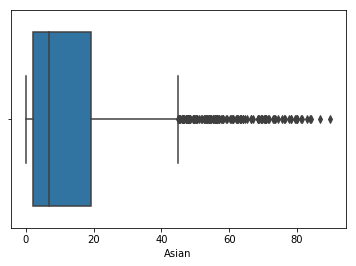

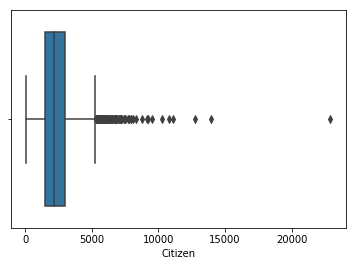

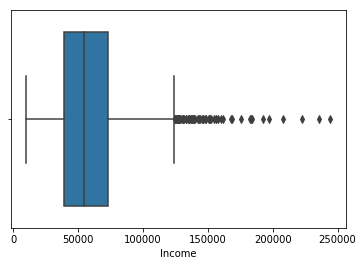

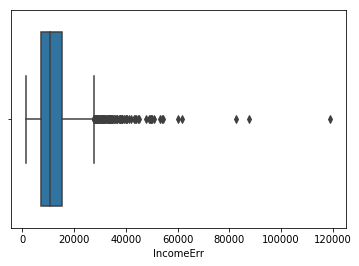

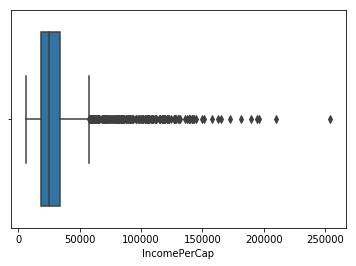

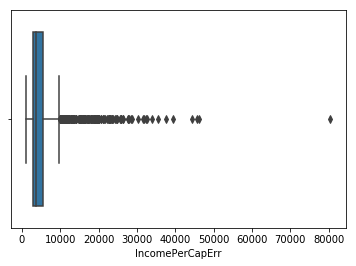

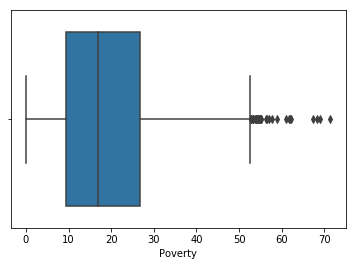

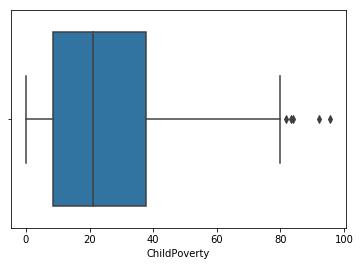

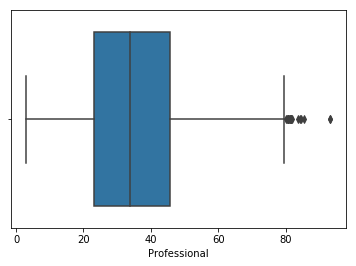

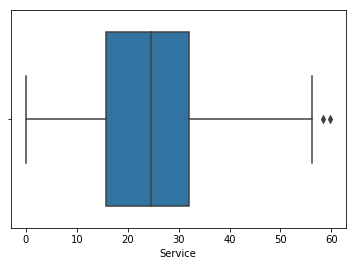

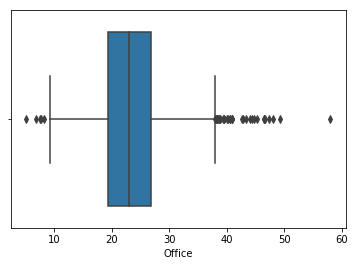

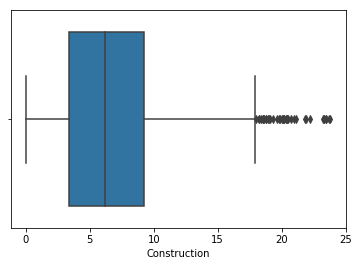

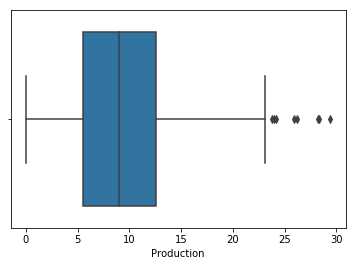

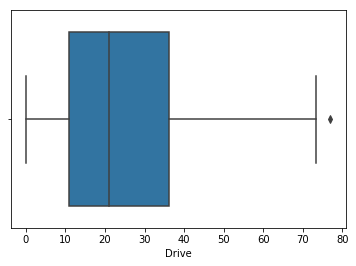

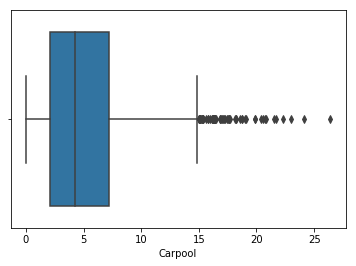

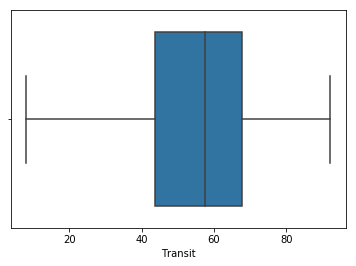

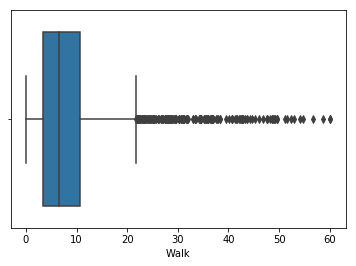

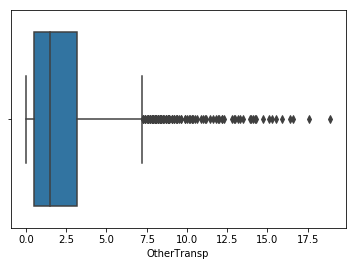

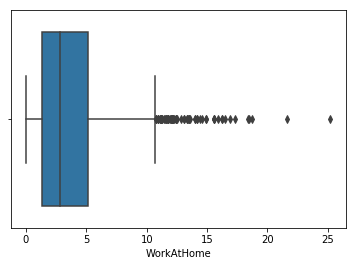

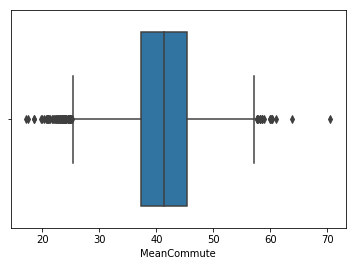

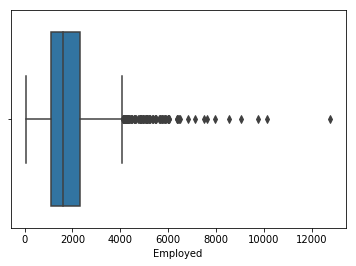

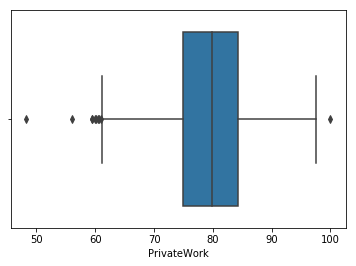

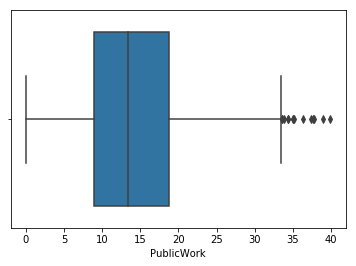

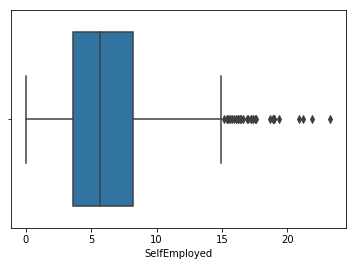

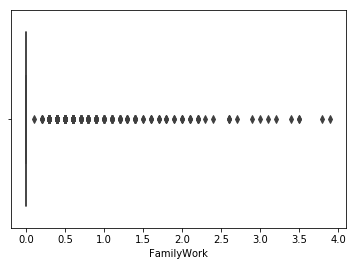

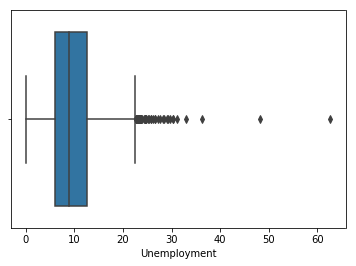

In [127]:
# Explore the data to check for outliers
columns = ['TotalPop', 'Men','Women','Hispanic','White','Black','Native','Asian', 
'Citizen','Income','IncomeErr', 'IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service',
'Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome',
'MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment'
]

for column in columns:
    sns.boxplot(nyc_df[column])
    plt.show()


 It appears there are no unreasonable outliers in our dataset and winsorization or other
 data cleaning methods are not necessary.

## Data Exploration

Let's take a look at the relationship between our variables and the target variable, median household income.

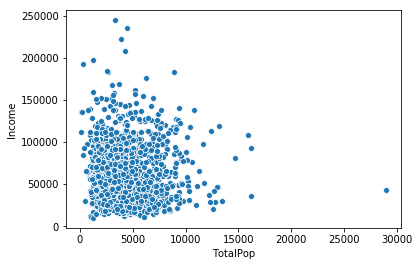

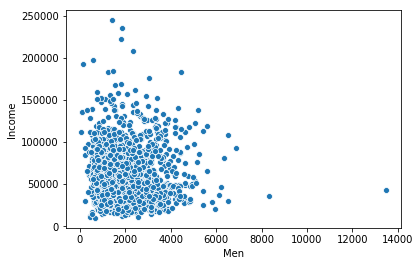

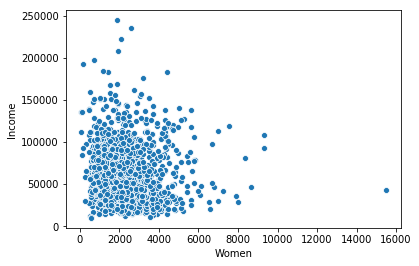

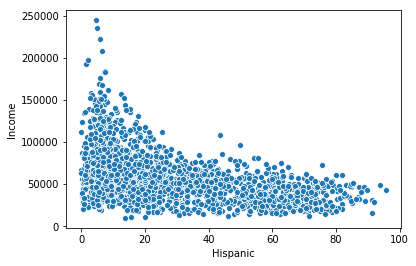

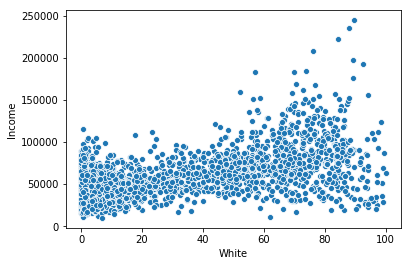

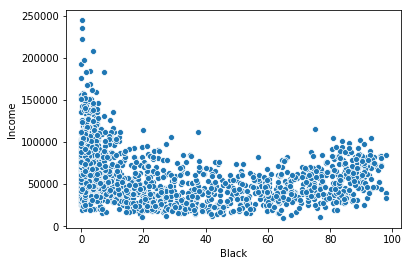

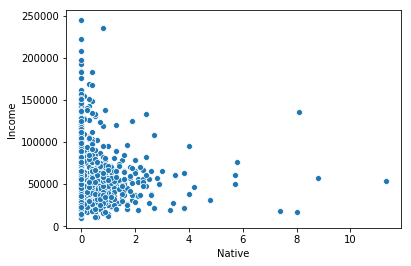

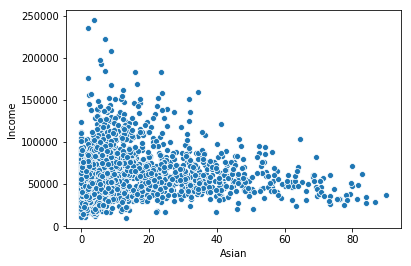

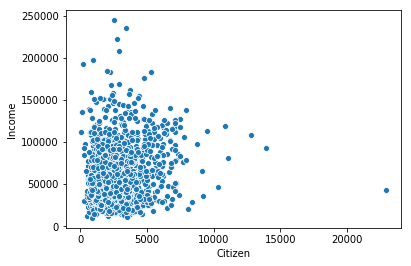

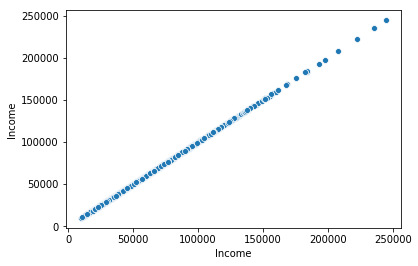

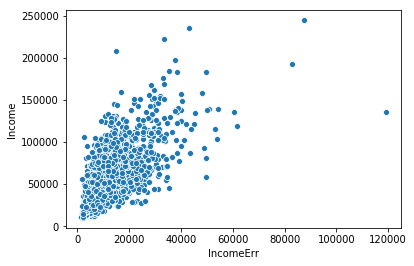

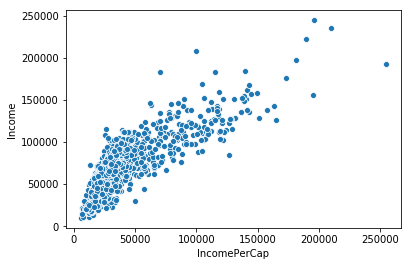

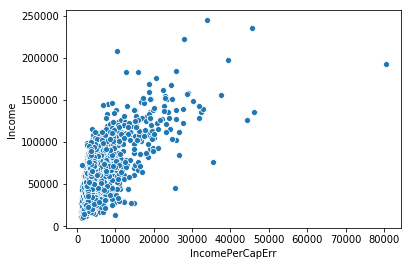

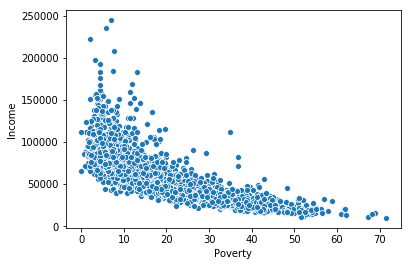

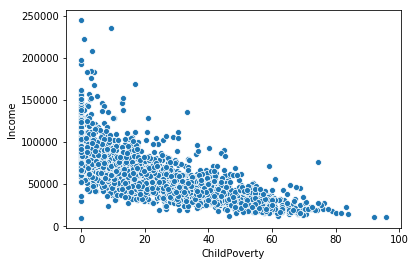

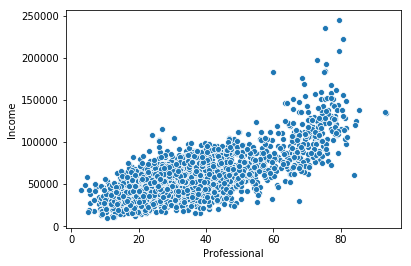

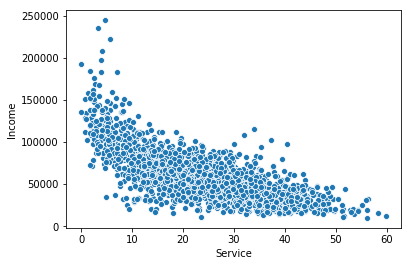

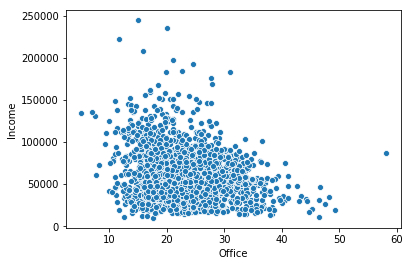

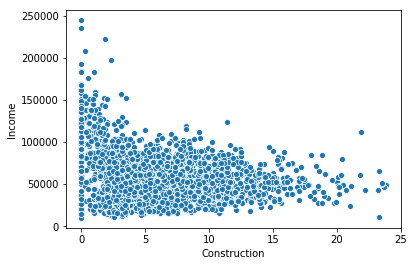

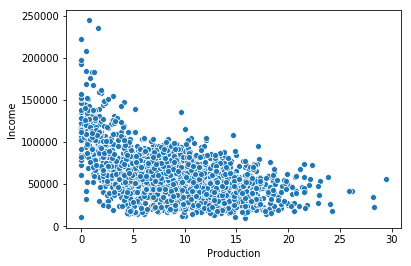

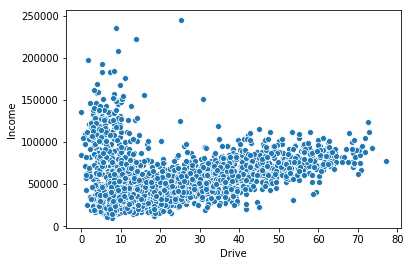

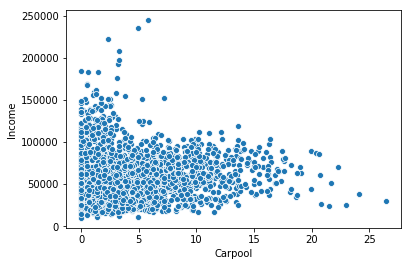

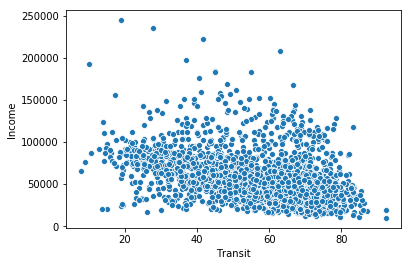

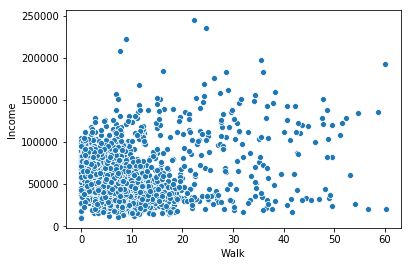

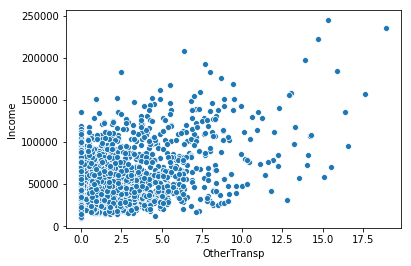

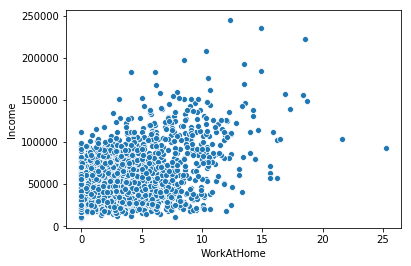

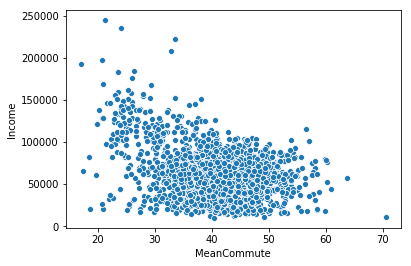

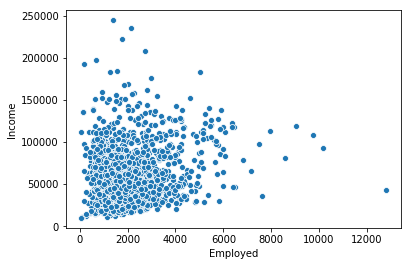

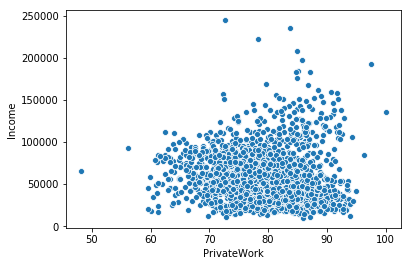

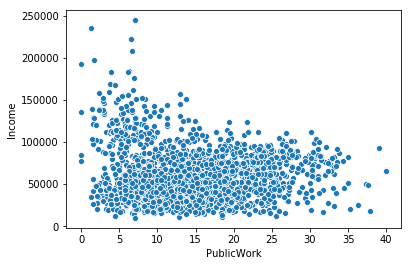

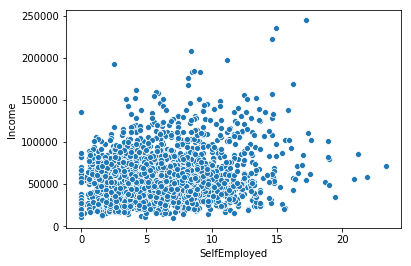

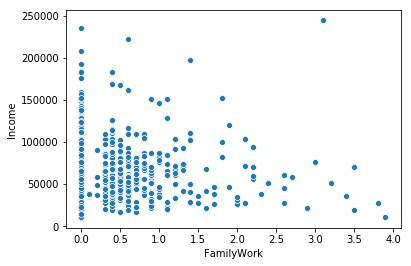

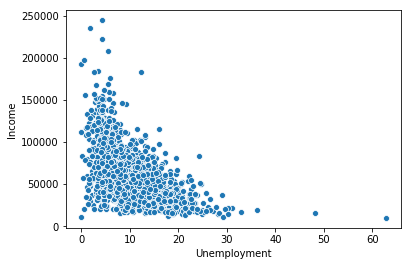

In [128]:
for column in columns:
    sns.scatterplot(nyc_df[column], nyc_df['Income'])
    plt.show()

Viewing the plots, it appears highly correlated variables with Median household income include Income Error, Income per Cap, Professional, White, and Self Employed. It is not surprising that income scores are highly correlated with their respective error scores, and this isn't really of interest to us in this experiment. As a result we will drop the error columns.

In [129]:
nyc_df = nyc_df.drop(columns = ['IncomePerCapErr','IncomeErr'])

Negatively correlated variables with Median Household Income include Hispanic, Poverty, Child Poverty, Service, Production, and Unemployment. All of these variables are of interest in this experiment.

Let's take a look at the correlation matrix to see if we have missed any highly correlated variables.

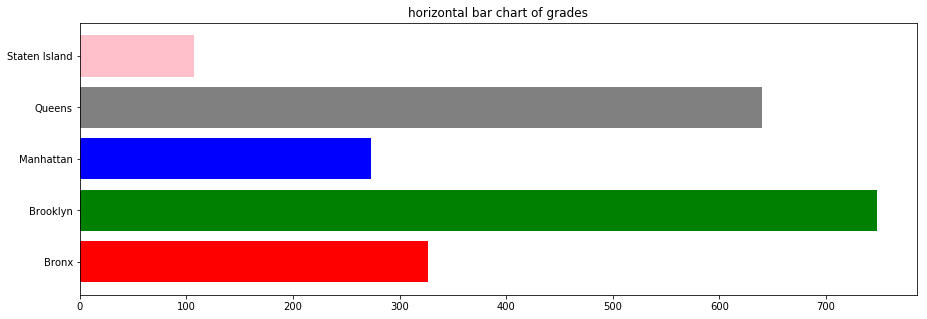

In [130]:
#Let's take a look to see the number of rows in each Borough
plt.figure(figsize=(15,5))
plt.barh(nyc_df.groupby("Borough")["Borough"].count().index, 
        nyc_df.groupby("Borough")["Borough"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of grades")

plt.show()

There appears to be a significant difference in the amount of data collected per borough, with Brooklyn having over double the amount of data as the Bronx, Manhattan, and Staten Island. We will convert to dummies in order to include them in our models.


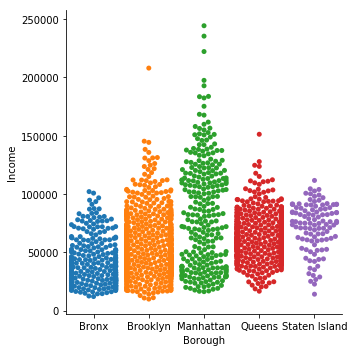

In [131]:
#Let's see the data for income in each Borough.
sns.catplot(x="Borough", y="Income", kind = 'swarm', data=nyc_df);

The distribution of income does appear to vary between the boroughs, with Manhattan having the highest income distribution and Staten Island and the Bronx having the lowest of the five boroughs.

In [132]:
nyc_df = pd.get_dummies(nyc_df)
nyc_df.head()

,CensusTract,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
1,36005000200,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,...,80.8,16.2,2.9,0.0,7.7,1,0,0,0,0
2,36005000400,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,...,71.7,25.3,2.5,0.6,9.5,1,0,0,0,0
3,36005001600,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,...,75.0,21.3,3.8,0.0,8.7,1,0,0,0,0
4,36005001900,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,...,76.8,15.5,7.7,0.0,19.2,1,0,0,0,0
5,36005002000,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,...,71.0,21.3,7.7,0.0,17.2,1,0,0,0,0


In [133]:
#Let's take a look at the correlation matrix to see if we want to include any boroughs in the model.

nyc_df.corr()

,CensusTract,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
CensusTract,1.000000,-0.039857,-0.018568,-0.057264,-0.342898,0.192393,-0.158930,0.000812,0.347348,0.013088,...,-0.058720,0.021368,0.065910,0.013164,-0.342252,-0.824070,-0.218376,0.095333,0.676703,0.272190
TotalPop,-0.039857,1.000000,0.982715,0.986937,0.185062,-0.022382,-0.099822,-0.033576,-0.015780,0.924217,...,0.140554,-0.162264,0.060381,0.012287,0.019690,0.065474,-0.186167,0.340465,-0.127608,0.043595
Men,-0.018568,0.982715,1.000000,0.940053,0.208436,-0.001702,-0.156635,-0.035618,0.014345,0.889945,...,0.179249,-0.212480,0.088227,0.015556,-0.014781,0.052228,-0.194066,0.333011,-0.107624,0.052209
Women,-0.057264,0.986937,0.940053,1.000000,0.159520,-0.039749,-0.047576,-0.030855,-0.041552,0.928067,...,0.102930,-0.114005,0.034451,0.009097,0.049134,0.075160,-0.174061,0.337382,-0.141412,0.034874
Hispanic,-0.342898,0.185062,0.208436,0.159520,1.000000,-0.490755,-0.150194,-0.003520,-0.178838,-0.015767,...,0.227493,-0.228402,0.033693,-0.021907,0.335453,0.499036,-0.279244,-0.062106,-0.018065,-0.082202
White,0.192393,-0.022382,-0.001702,-0.039749,-0.490755,1.000000,-0.625442,-0.081991,-0.005841,0.153980,...,0.081250,-0.161667,0.166002,0.057631,-0.503436,-0.286997,0.110087,0.196742,-0.133816,0.212684
Black,-0.158930,-0.099822,-0.156635,-0.047576,-0.150194,-0.625442,1.000000,0.017046,-0.436544,-0.095984,...,-0.396703,0.497247,-0.247895,-0.051444,0.386860,0.070122,0.185670,-0.137541,-0.098885,-0.102472
Native,0.000812,-0.033576,-0.035618,-0.030855,-0.003520,-0.081991,0.017046,1.000000,0.059316,-0.044646,...,0.005973,-0.000467,-0.009870,-0.004558,0.076273,0.008120,-0.017002,-0.000140,0.029170,-0.037202
Asian,0.347348,-0.015780,0.014345,-0.041552,-0.178838,-0.005841,-0.436544,0.059316,1.000000,-0.074857,...,0.249375,-0.270203,0.071868,0.019616,-0.231598,-0.254317,-0.113379,-0.029454,0.378688,-0.081262
Citizen,0.013088,0.924217,0.889945,0.928067,-0.015767,0.153980,-0.095984,-0.044646,-0.074857,1.000000,...,0.032212,-0.056321,0.050888,0.014578,-0.056347,-0.007351,-0.183775,0.435869,-0.166246,0.093401


## Modeling

We will be using the RMSE for each model to determine which model is the best in this scenario.


In [134]:
# OLS Models - Ridge and Lasso Regression
import statsmodels.api as sm
X = nyc_df[['Poverty','Professional','White','SelfEmployed','Service','Borough_Queens','Production','Unemployment']]
Y = nyc_df['Income']
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)
#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
Ridge_regr = RidgeCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)
Lasso_regr = LassoCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)


The number of observations in training set is 1676
The number of observations in test set is 419


In [135]:
# Ridge Regression

y_preds_train = Ridge_regr.predict(X_train)
y_preds_test = Ridge_regr.predict(X_test)
print("Best alpha value is: {}".format(Ridge_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Ridge_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Ridge_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
Ridge_RMSE = rmse(y_test, y_preds_test)

Best alpha value is: 1000.0
R-squared of the model in the training set is: 0.709186615831048
-----Test set statistics-----
R-squared of the model in the test set is: 0.7414949159649893
Mean absolute error of the prediction is: 10567.128056128917
Mean squared error of the prediction is: 213274631.29853302
Root mean squared error of the prediction is: 14603.925201757678
Mean absolute percentage error of the prediction is: 19.825746641618153


In [136]:
# Lasso Regression

y_preds_train = Lasso_regr.predict(X_train)
y_preds_test = Lasso_regr.predict(X_test)
print("Best alpha value is: {}".format(Lasso_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Lasso_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Lasso_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
Lasso_RMSE = rmse(y_test, y_preds_test) 

Best alpha value is: 100.0
R-squared of the model in the training set is: 0.7092486341977482
-----Test set statistics-----
R-squared of the model in the test set is: 0.7415845186432406
Mean absolute error of the prediction is: 10565.987794641465
Mean squared error of the prediction is: 213200706.33787408
Root mean squared error of the prediction is: 14601.393986119068
Mean absolute percentage error of the prediction is: 19.831693312951632


The Lasso and Ridge regression models produced similar scores for their RMSE values, with Ridge having a RMSE of 14603 and Lasso 14601.39. 

In [137]:
# Let's do some Cross Validation to see if the model is overfitting
models = [Lasso_regr,Ridge_regr]
from sklearn.model_selection import cross_val_score

for model in models:
        print(cross_val_score(model, X, Y, cv=10))


[0.67345756 0.76192385 0.71168377 0.26795075 0.722888   0.4242463
 0.54478526 0.25217267 0.46866379 0.61858553]
[0.665144   0.76293343 0.71123422 0.26684404 0.70809371 0.42448005
 0.54425213 0.26239161 0.46080631 0.61206408]


This is not good.

In [139]:
# Let's try a Random Forest model.
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=2000, random_state=0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Income in Dataset:', np.mean(nyc_df['Income']))
print('The Random Forest Regressor is predicting the median household income at {}%'.format(100*(1 - (metrics.mean_absolute_error(y_test, y_pred))/np.mean(nyc_df['Income']))))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
Forest_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 8292.753196897374
Mean Income in Dataset: 59135.96372315036
The Random Forest Regressor is predicting the median household income at 85.97680214408858%
Root Mean Squared Error: 12398.053880925592


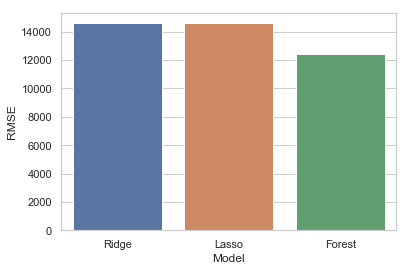

In [149]:
### RMSE illustration for different models to chose the best one for this scenario
from pandas import DataFrame

data = {'Model':['Ridge','Lasso','Forest'],'RMSE':[Ridge_RMSE,Lasso_RMSE,Forest_RMSE]}
Ridge_df = DataFrame(data, columns=['Model','RMSE'])

sns.set(style="whitegrid")
sns.barplot(x="Model", y="RMSE", data=Ridge_df)

The best model based on the RMSE criteria appears to be the Random Forest model, which has an RMSE value that is significantly lower than the Ridge and Lasso regression models. 